<a href="https://colab.research.google.com/github/rne1223AI/google_colabs/blob/main/automatic_mask_generator_WMS_Invernaderos_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatically generating object masks with SAM

[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeos/segment-geospatial/blob/main/docs/examples/automatic_mask_generator.ipynb)
[![image](https://img.shields.io/badge/Open-Planetary%20Computer-black?style=flat&logo=microsoft)](https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/git-pull?repo=https://github.com/opengeos/segment-geospatial&urlpath=lab/tree/segment-geospatial/docs/examples/automatic_mask_generator.ipynb&branch=main)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/automatic_mask_generator.ipynb)

This notebook shows how to segment objects from an image using the Segment Anything Model (SAM) with a few lines of code. 

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator. 

The notebook is adapted from [segment-anything/notebooks/automatic_mask_generator_example.ipynb](https://github.com/opengeos/segment-anything/blob/pypi/notebooks/automatic_mask_generator_example.ipynb), but I have made it much easier to save the segmentation results and visualize them.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [1]:
 %pip install segment-geospatial leafmap localtileserver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [3]:
import os
from google.colab import files
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## Create an interactive map

In [4]:
# m = leafmap.Map(center=[37.8713, -122.2580], zoom=17, height="800px")
# m.add_basemap("SATELLITE")
# m

m = leafmap.Map(center=[36.718522, -2.744180], zoom=15)
naip_url = 'https://www.ign.es/wms-inspire/pnoa-ma?'
m.add_wms_layer(
    url=naip_url,
    layers='OI.OrthoimageCoverage',
    name='Ortoimagen MA PNOA',
    attribution='PNOA',
    format='image/png',
    shown=True,
)
m



Map(center=[36.718522, -2.74418], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …


Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [5]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
    #print(bbox)
else:
    bbox = [-2.7434, 36.7088, -2.726, 36.7172]

## Download a sample image

In [6]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/35
Downloaded image 2/35
Downloaded image 3/35
Downloaded image 4/35
Downloaded image 5/35
Downloaded image 6/35
Downloaded image 7/35
Downloaded image 8/35
Downloaded image 9/35
Downloaded image 10/35
Downloaded image 11/35
Downloaded image 12/35
Downloaded image 13/35
Downloaded image 14/35
Downloaded image 15/35
Downloaded image 16/35
Downloaded image 17/35
Downloaded image 18/35
Downloaded image 19/35
Downloaded image 20/35
Downloaded image 21/35
Downloaded image 22/35
Downloaded image 23/35
Downloaded image 24/35
Downloaded image 25/35
Downloaded image 26/35
Downloaded image 27/35
Downloaded image 28/35
Downloaded image 29/35
Downloaded image 30/35
Downloaded image 31/35
Downloaded image 32/35
Downloaded image 33/35
Downloaded image 34/35
Downloaded image 35/35
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


You can also use your own image. Uncomment and run the following cell to use your own image.

In [ ]:
# image = 'https://drive.google.com/file/d/1P-u2-zCZTF_L2jotsf9bLigU-R0DSOcE/view?usp=sharing'
#leafmap.download_file(image, 'image.tif', unzip=False)





Downloading...
From: https://drive.google.com/uc?id=1P-u2-zCZTF_L2jotsf9bLigU-R0DSOcE
To: /content/image.tif
100%|██████████| 414k/414k [00:00<00:00, 70.6MB/s]


'/content/image.tif'

Display the downloaded image on the map.

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [ ]:
out_dir = os.path.join(os.path.expanduser("~"), "Downloads")
checkpoint = os.path.join(out_dir, "sam_vit_h_4b8939.pth")

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=None,
)

Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/Downloads/sam_vit_h_4b8939.pth


Checkpoint /root/Downloads/sam_vit_h_4b8939.pth does not exist.


100%|██████████| 2.56G/2.56G [00:11<00:00, 230MB/s]


## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object. 

In [ ]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

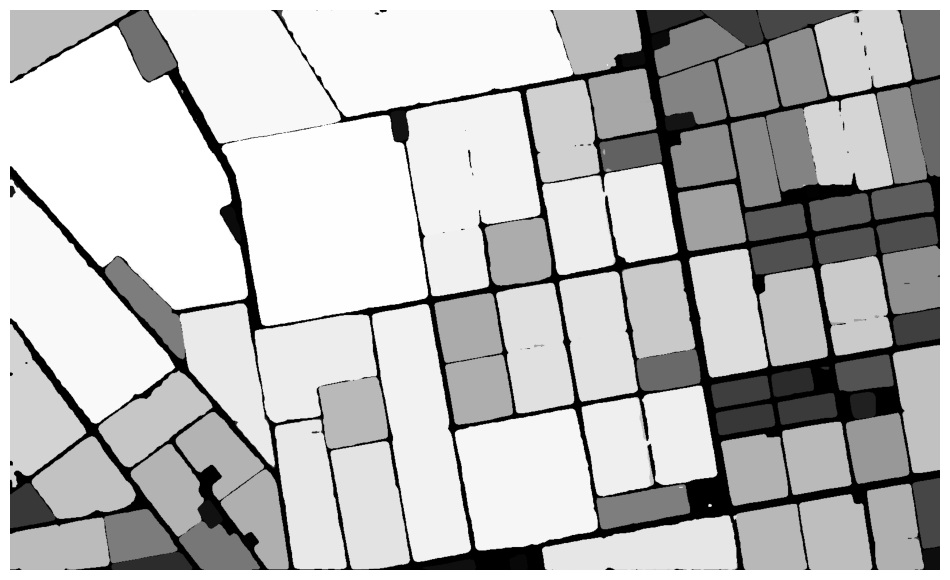

In [ ]:
sam.show_masks(cmap="binary_r")

Show the object annotations (objects with random color) on the map.

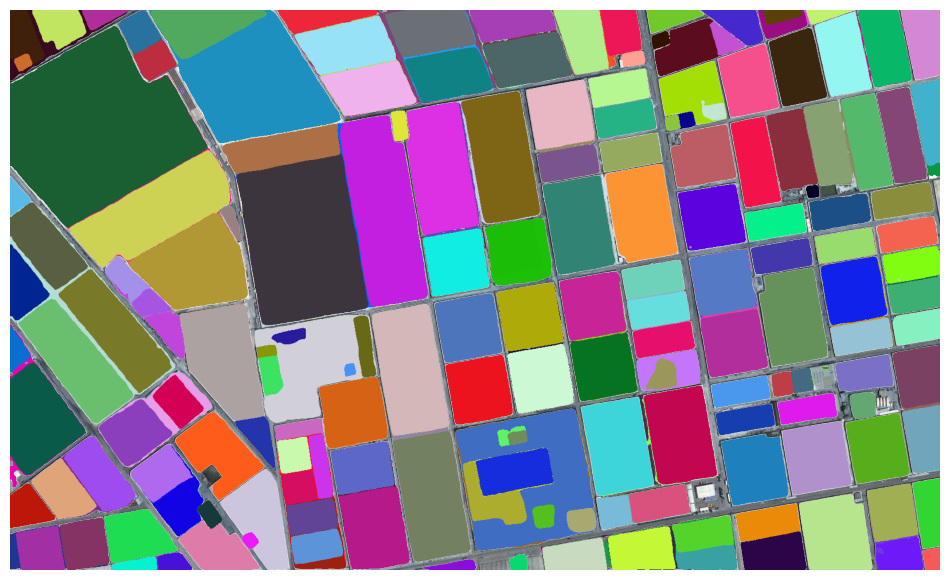

In [ ]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

Compare images with a slider.


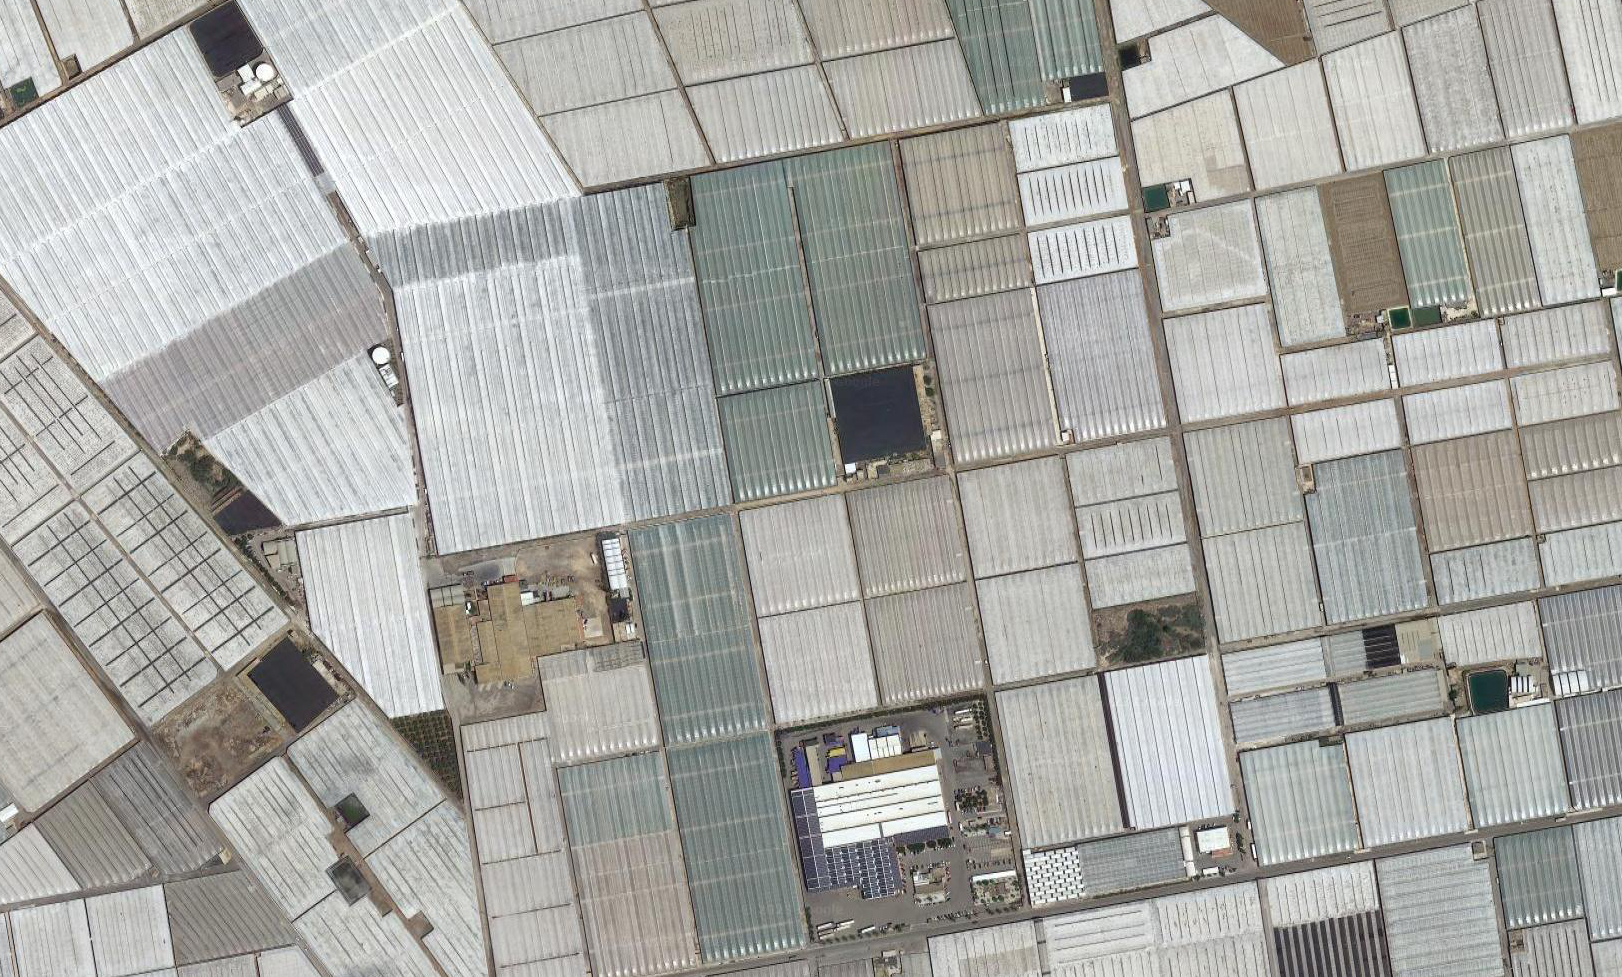
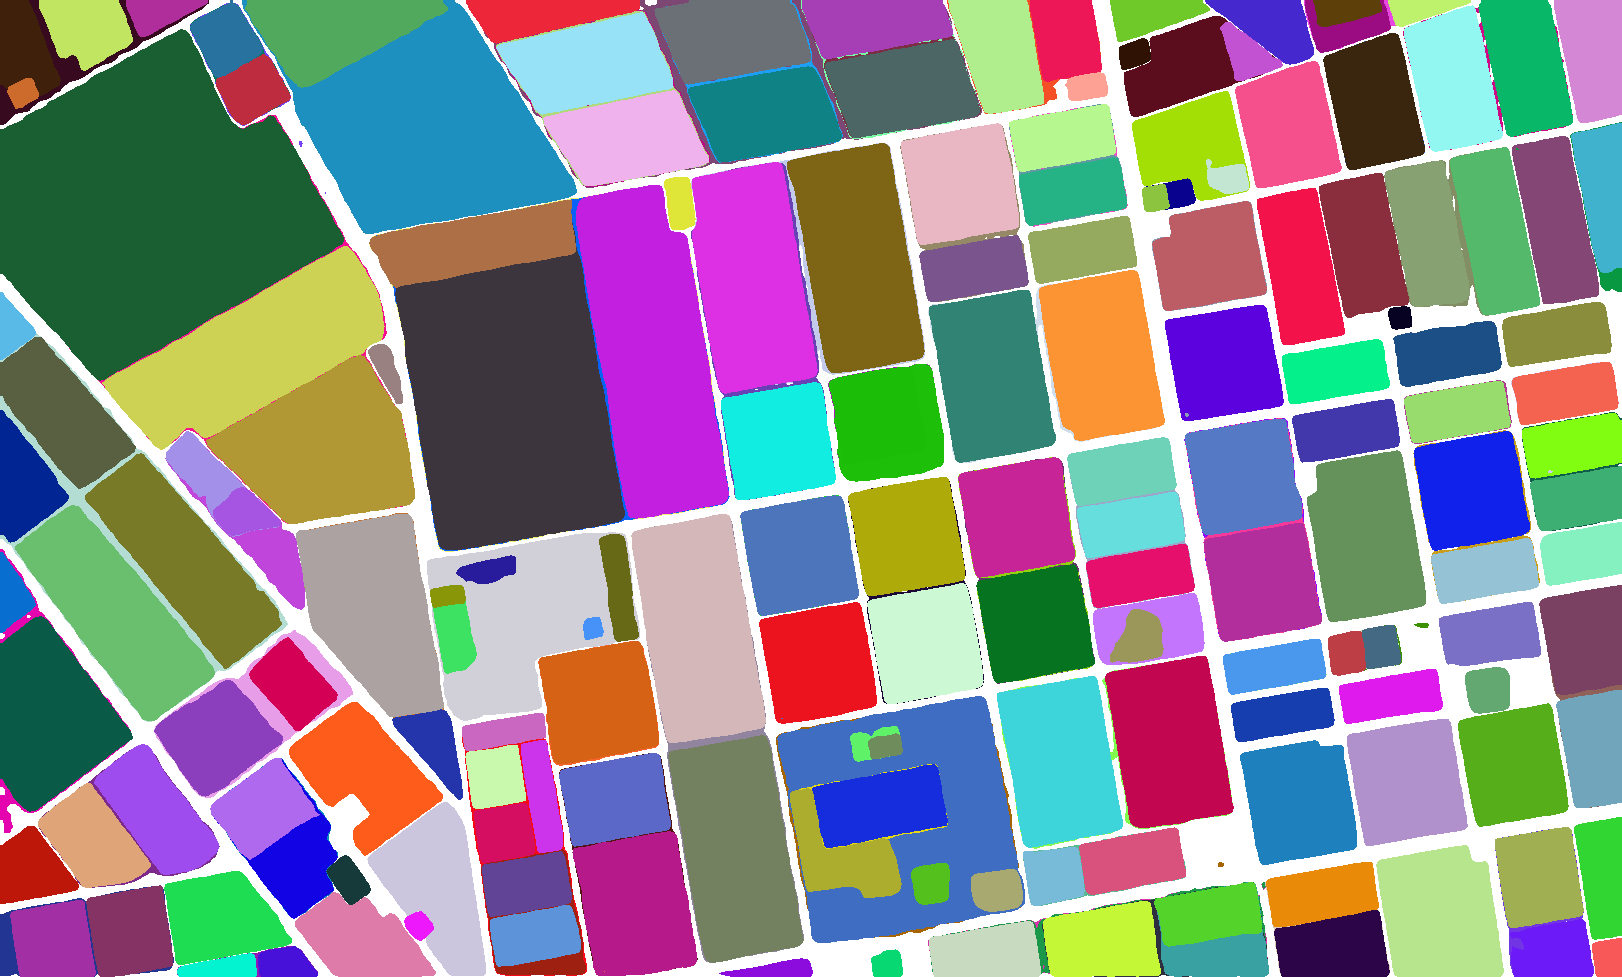

In [ ]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Add image to the map.

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [ ]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=sam_kwargs,
)

In [ ]:
sam.generate(image, output="masks2.tif", foreground=True)

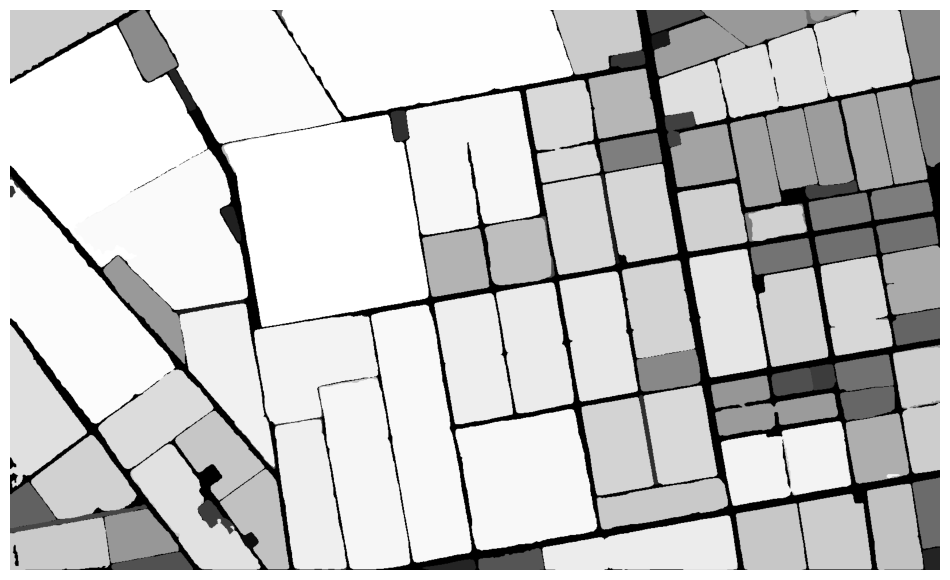

In [ ]:
sam.show_masks(cmap="binary_r")

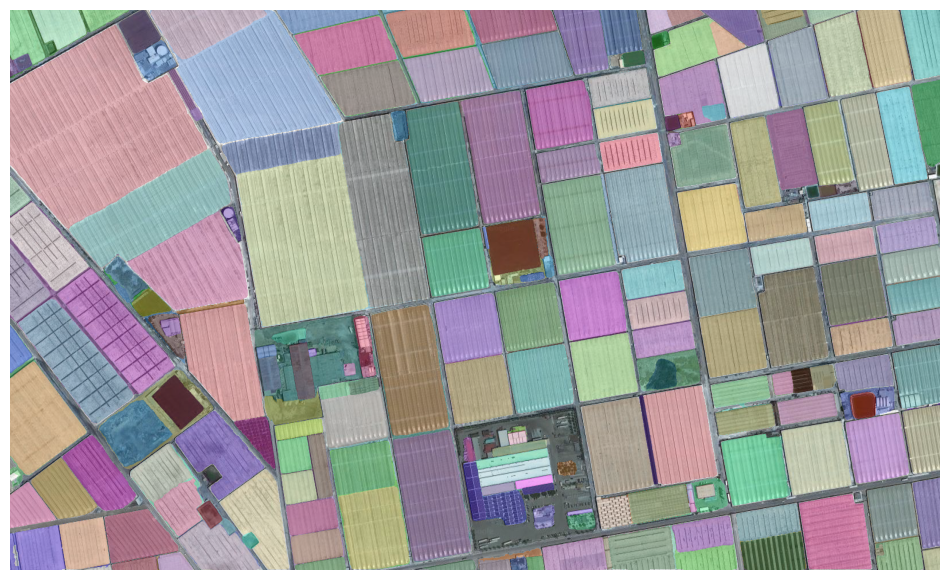

In [ ]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")

Compare images with a slider.


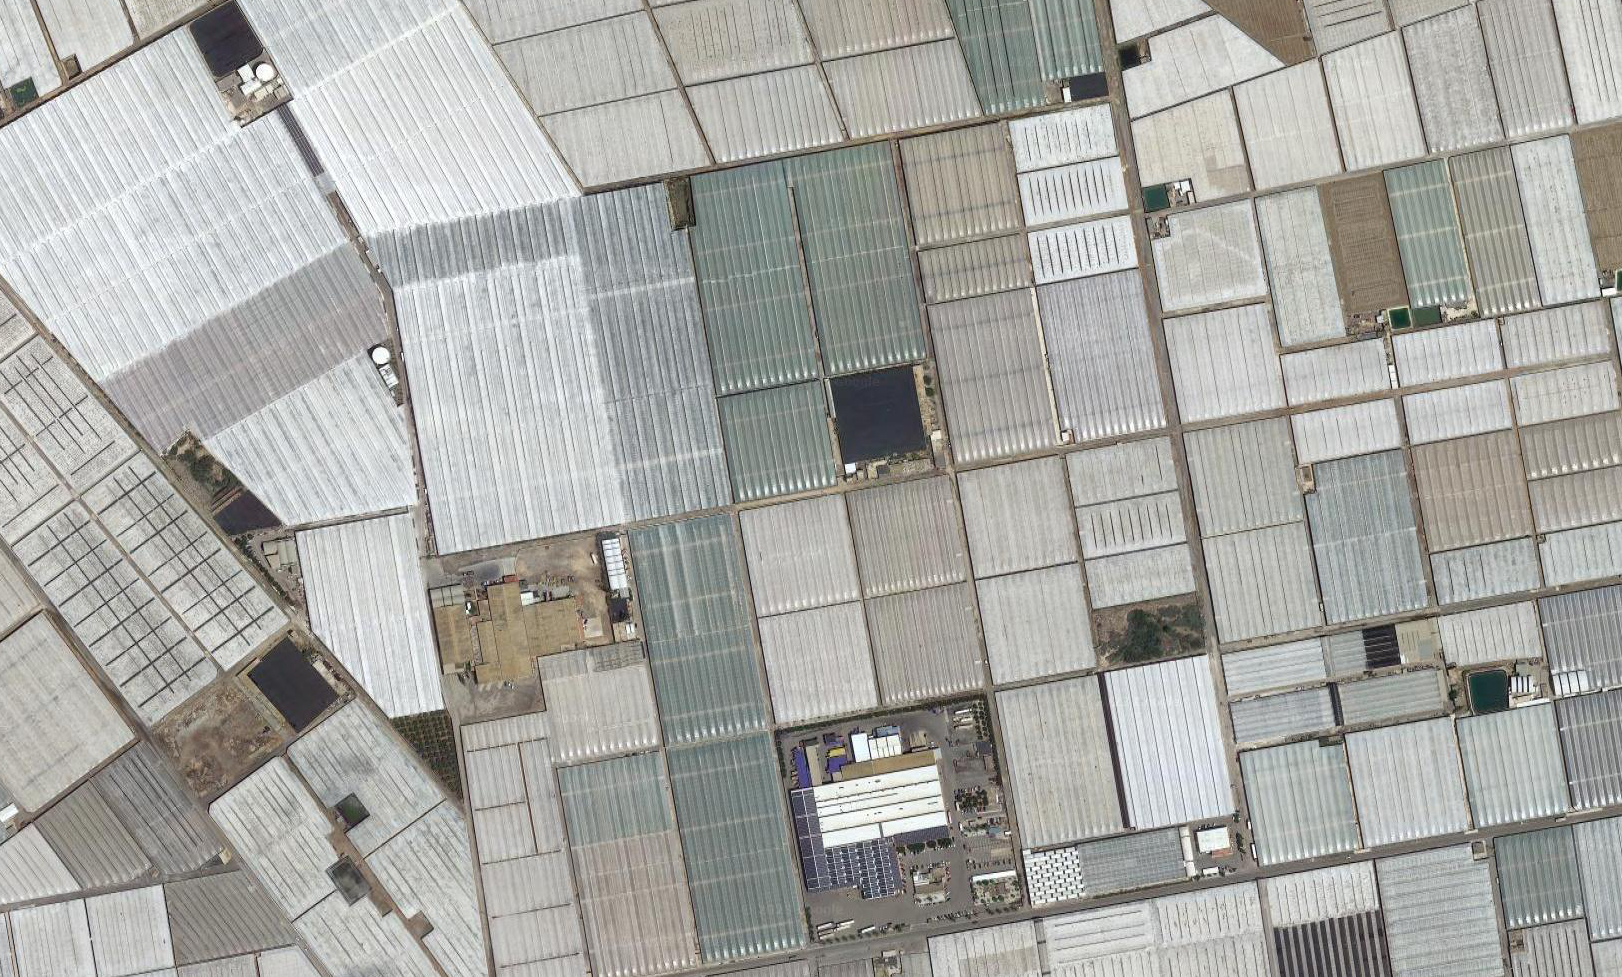
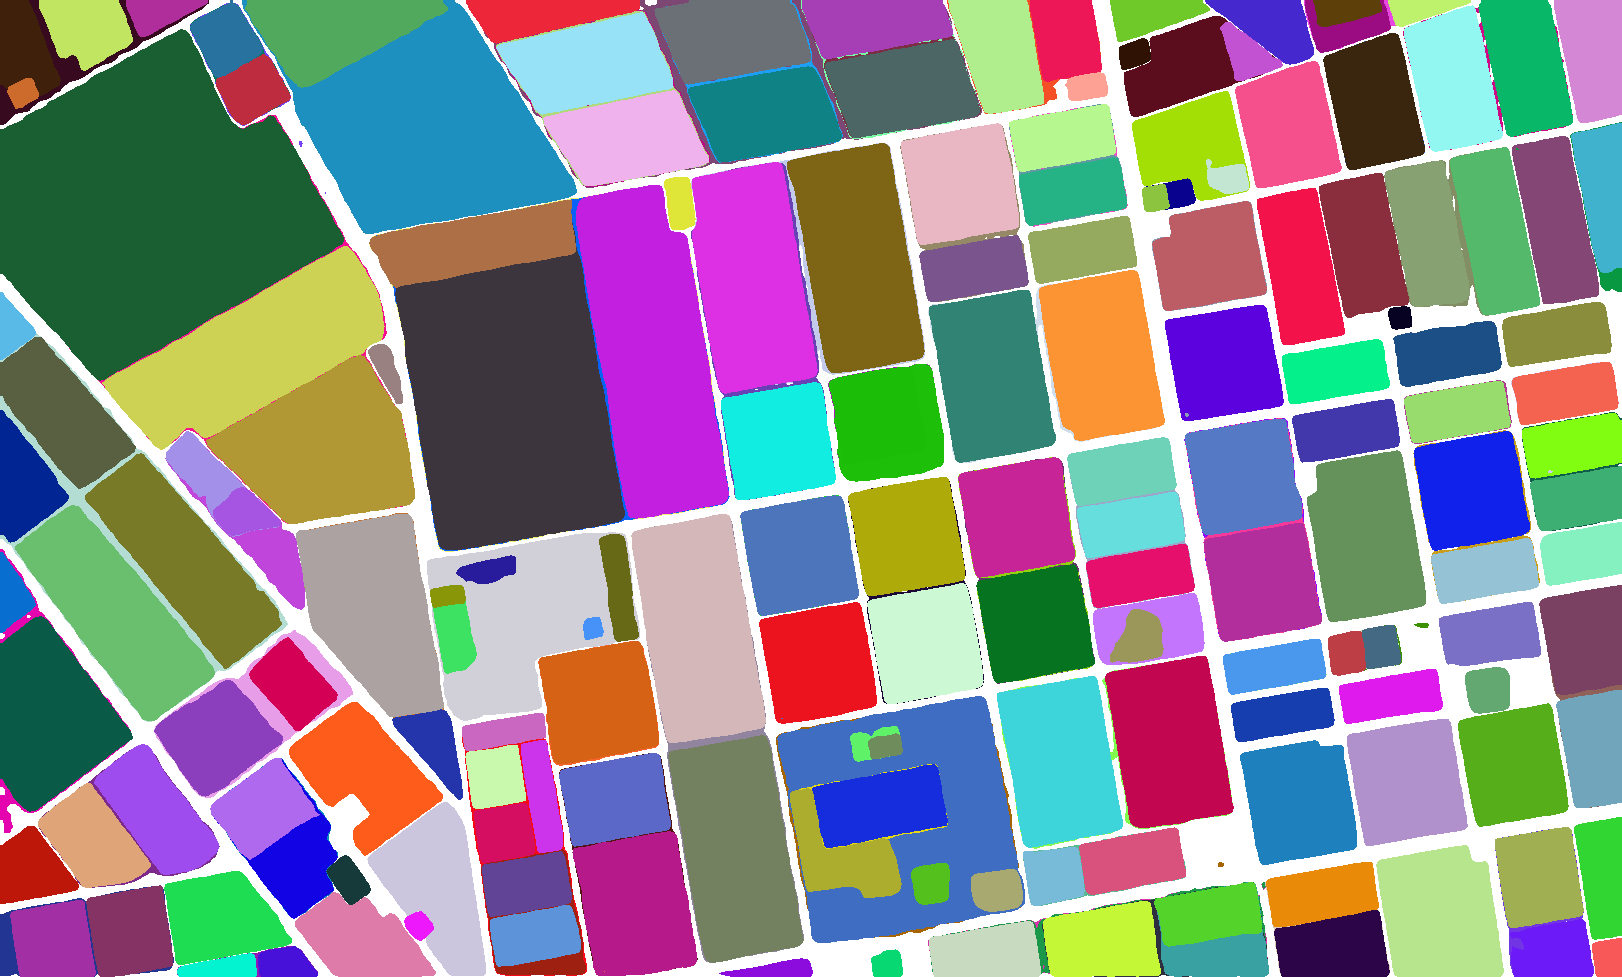

In [ ]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Overlay the annotations on the image and use the slider to change the opacity interactively.

Download the results

In [ ]:
files.download("satellite.tif")
files.download("masks.gpkg")
files.download("annotations2.tif")
files.download("masks2.tif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>